In [1]:
# %%
import logging
logging.basicConfig(level=logging.WARNING)
import tracelogger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True # avoid warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Process, Pipe



In [ ]:
# %%
from childfunctions import *

# %%
# Directory for memory mapped files
memorydir = '~/tmp/' 

# File to store results, in case program fails to complete
resultsfilename = 'results.txt'

# define array sizes to test
# sizes = {f'1e{i}':10**i for i in range(3,7)}
sizes = {f'1e{i}':10**i for i in range(3,10)}
sizes['3e9'] = (int(3e9))

    


INFO:childfunctions:Testing sort for the following array sizes: {'1e3': 1000, '1e4': 10000, '1e5': 100000, '1e6': 1000000, '1e7': 10000000, '1e8': 100000000, '1e9': 1000000000, '3e9': 3000000000}
INFO:childfunctions:Running 1e3, 1000
INFO:childfunctions:Elapsed time: 0.000113 seconds
DEBUG:childfunctions:Writing results to results.txt
INFO:childfunctions:Elapsed time: 0.000035 seconds
DEBUG:childfunctions:Writing results to results.txt
INFO:childfunctions:Running 1e4, 10000
INFO:childfunctions:Elapsed time: 0.000472 seconds
DEBUG:childfunctions:Writing results to results.txt
INFO:childfunctions:Elapsed time: 0.000117 seconds
DEBUG:childfunctions:Writing results to results.txt
INFO:childfunctions:Running 1e5, 100000
INFO:childfunctions:Elapsed time: 0.005626 seconds
DEBUG:childfunctions:Writing results to results.txt
INFO:childfunctions:Elapsed time: 0.001136 seconds
DEBUG:childfunctions:Writing results to results.txt
INFO:childfunctions:Running 1e6, 1000000
INFO:childfunctions:Elapsed 

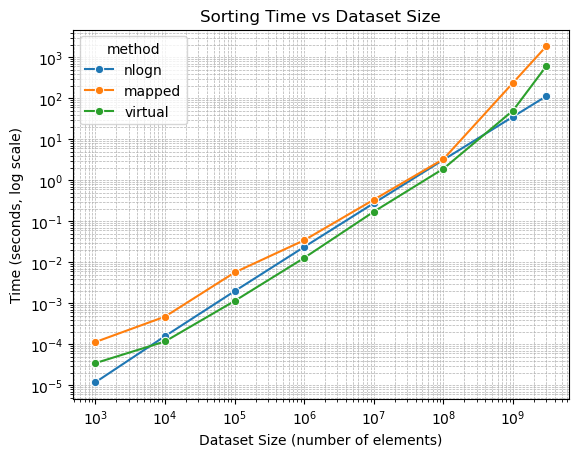

In [3]:
# %%
if __name__ == '__main__':

    EXECUTE_TESTS = True
    if EXECUTE_TESTS:
    
        results = pd.DataFrame(columns=['n', 'method', 'time']
                    ).astype({'n': 'int', 'method': 'str', 'time': 'float64'})
        
        #
        # Run tests
        #
        logger.info(f'Testing sort for the following array sizes: {sizes}') 
        for name, n in sizes.items():
            
            nlogn = n * np.log(n)
            results.loc[len(results)] = {'n': n, 'method': 'nlogn', 'time': nlogn}
            results.to_csv(resultsfilename, index=False)

            logger.info(f"Running {name}, {n}")

            elapsed = run_safely(mapped_sort, name, n, memorydir)
            if elapsed is None:
                logger.info(f"Elapsed time is unknown")        
            else: 
                logger.info(f"Elapsed time: {elapsed:.6f} seconds")
                results.loc[len(results)] = {'n': n, 'method': 'mapped', 'time': elapsed}
            
            logger.debug(f"Writing results to {resultsfilename}")
            results.to_csv(resultsfilename, index=False)

            elapsed = run_safely(virtual_sort, name, n)
            if elapsed is None:
                logger.info(f"Elapsed time is unknown")        
            else: 
                logger.info(f"Elapsed time: {elapsed:.6f} seconds")
                results.loc[len(results)] = {'n': n, 'method': 'virtual', 'time': elapsed}
                
            logger.debug(f"Writing results to {resultsfilename}")
            results.to_csv(resultsfilename, index=False)
        
    #
    # Plot results
    # 
    if not EXECUTE_TESTS:
        logger.info(f'Reading results from {resultsfilename}')
        results = pd.read_csv(resultsfilename)    

    # Adjust the estimates so nlogn line is on same scale as other lines
    #
    logger.debug(f"\n{results}")
    #print(logger)
    #print(results)
    min_n = 10**6
    avg_time = results.query('method != "nlogn"and n == @min_n').time.mean()
    nlogn_time = results.query('method == "nlogn"and n == @min_n').time.iloc[0]
    scale = nlogn_time / avg_time
    logger.debug(f' scale = {scale}, min_n = {min_n}, avg_time = {avg_time} nlogn_time={nlogn_time}')
    results['time'] = np.where(
        results.method == 'nlogn',
        results.time / scale,
        results.time)
    logger.debug(f"\n{results}\n")

    sns.lineplot(data=results, x='n', y='time', hue='method', marker='o')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Sorting Time vs Dataset Size')
    plt.xlabel('Dataset Size (number of elements)')
    plt.ylabel('Time (seconds, log scale)')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()


# %%
